**Mines Paris 2025**

Deep Learning for Image Analisis

Practical Session: Oct 21-2025

You should submit the notebook with the answers by email before the deadline.

Deadline: Oct 27-2025

etienne.decenciere@minesparis.psl.eu

Teaching assistants:

leo.dechaumet@minesparis.psl.eu

camille.robin@minesparis.psl.eu

# Segmentation

In this notebook you will train and test a deep learning model to perform binary image segmentation. Segmentation is a very common tool in image analysis. In particular, binary segmentation is used to locate some particular elements in an image, which will be labeled in white while the rest of the image remains black, like in [this example](https://i.stack.imgur.com/i24FE.png):

<a href="https://i.sstatic.net/i24FE.png"><img src="https://i.sstatic.net/i24FE.png" title="segmentation"/></div>

This notebook deals with Whole Slide Images (WSI). Whole slide imaging, also known as virtual microscopy, refers to scanning a complete microscope slide and creating a single high-resolution digital file. For more information, see [this introduction](https://www.mbfbioscience.com/whole-slide-imaging-analysis).

In [1]:
import os
import json
from datetime import datetime
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.keras import backend as K
import imageio.v2 as imageio
import numpy as np
from scipy import ndimage
import pandas as pd
import matplotlib.pyplot as plt
import random

## Data

Drag and drop the tissue-20221017T082544Z-001.zip into the colab files. Once done run the cell below to unzip the files into the 'data' folder.

Have a look at the different images in the folder, both initial images and their associated binary mask. As you can see some of them are quite messy with dirt, pen marks... The objective of this work is to create a model to segment these WSI images to remove these unwanted details.

In [2]:
!unzip tissue.zip -d data

Archive:  tissue.zip
  inflating: data/tissue/val/.DS_Store  
  inflating: data/tissue/test/.DS_Store  
  inflating: data/tissue/train/.DS_Store  
  inflating: data/tissue/test/lbl/492074.jpg  
  inflating: data/tissue/test/lbl/480874.jpg  
  inflating: data/tissue/test/lbl/500202.jpg  
  inflating: data/tissue/test/lbl/545966.jpg  
  inflating: data/tissue/test/lbl/520051.jpg  
  inflating: data/tissue/test/lbl/574866.jpg  
  inflating: data/tissue/test/lbl/581037.jpg  
  inflating: data/tissue/test/lbl/508023.jpg  
  inflating: data/tissue/test/lbl/520556.jpg  
  inflating: data/tissue/test/lbl/533396.jpg  
  inflating: data/tissue/test/lbl/565522.jpg  
  inflating: data/tissue/test/lbl/83549.jpg  
  inflating: data/tissue/test/lbl/85647.jpg  
  inflating: data/tissue/test/lbl/569254.jpg  
  inflating: data/tissue/test/lbl/488883.jpg  
  inflating: data/tissue/test/lbl/579843.jpg  
  inflating: data/tissue/test/lbl/542401.jpg  
  inflating: data/tissue/test/lbl/82487.jpg  
  inflatin

# Fetching data

First step is to implement functions to send data to the training and testing pipeline. To do so, we implement the class DataGeneratorTissue used to select patches of images by customising keras DataGenerator class.  

The function `get_random_patch_coord` randomly selects the coordinates of an image's patch, or crop. A `patch_coord` point to the top left corner of the corresponding patch. Thus the coordinates [y, x] gives for a patch of size [h, w] the image's patch *image* [y:y+h, x:x+w].


The function `choose_patch_coord` calls `get_random_patch_coord` and should return the coordinates of a patch with at most 70% of background labels (pixel value of 0 in label). If it cannot be achieved after 10 tryouts, the function should return the coordinates of the patch with the lowest background labels found.  

The original Ground Truth label in the dataset is a binary image (single channel).

In this notebook, we want to use 2-channel label - the first channel represents the background, while the second one is the foreground, containing the objects of interest (the original binary label image).

In [3]:
class DataGeneratorTissue(keras.utils.Sequence):

    def __init__(self, path, prefix, batch_size,
                 patch_size, nb_channels_in=3, nb_channels_out=2,
                 geometric_augmentations=[], augmentation_ratio=None):

        self.path = path
        self.prefix = prefix
        self.get_data_dict()
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.nb_channels_in = nb_channels_in
        self.nb_channels_out = nb_channels_out
        self.geometric_augmentations = []
        self.augmentation_ratio = augmentation_ratio

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, batch_idx):
        batch_data_idxs = self.data_idxs[batch_idx*self.batch_size:(batch_idx+1)*self.batch_size]
        x, y = self.fetch_data(batch_data_idxs)
        return x, y

    def on_epoch_end(self):
        self.data_idxs = np.arange(len(self.data))
        np.random.shuffle(self.data_idxs)

    def get_data_dict(self):
        self.data = {}
        for data_idx, image_name in enumerate(os.listdir(os.path.join(*[self.path, self.prefix, "jpg"]))):
            self.data[data_idx] = image_name

    def get_random_patch_coord(self, image_size):
        '''
        image_size: (height, width)
        '''

        ### TO BE IMPLEMENTED ### (hint: use np.random.randint)
        patch_h, patch_w = self.patch_size
        max_y = image_size[0] - patch_h
        max_x = image_size[1] - patch_w
        y = np.random.randint(0, max_y + 1)
        x = np.random.randint(0, max_x + 1)
        patch_coord = [y, x]
        #########################

        return patch_coord

    def choose_patch_coord(self, image_shape, label, threshold=0.7):
        '''
        image_shape: (height, width)
        label: shape (height, width, channels)
        '''

        ### TO BE IMPLEMENTED ###
        patch_h, patch_w = self.patch_size
        best_bg_fraction = 1.0
        best_patch_coord = self.get_random_patch_coord(image_shape)  # initialize with a random patch

        for _ in range(10):
            coord = self.get_random_patch_coord(image_shape)
            y, x = coord
            label_patch = label[y:y + patch_h, x:x + patch_w, 0]
            bg_fraction = np.sum(label_patch == 0) / (patch_h * patch_w)

            if bg_fraction <= threshold:
                return coord

            if bg_fraction < best_bg_fraction:
                best_bg_fraction = bg_fraction
                best_patch_coord = coord
        #########################

        return best_patch_coord

    def fetch_data(self, batch_data_idxs):
        x = np.empty([self.batch_size, *self.patch_size, self.nb_channels_in])
        y = np.empty([self.batch_size, *self.patch_size, self.nb_channels_out])

        for idx, data_idx in enumerate(batch_data_idxs):
            image_file_path = os.path.join(*[self.path, self.prefix, "jpg", self.data[data_idx]])
            image = imageio.imread(image_file_path)

            label_file_path = os.path.join(*[self.path, self.prefix, "lbl", self.data[data_idx]])
            label = imageio.imread(label_file_path)

            image = np.float32(image/255)
            label = np.expand_dims(np.float32(label/255), axis=-1)

            patch_coord = self.choose_patch_coord(list(image.shape[:2]), label)

            image_patch = image[patch_coord[0]:patch_coord[0]+self.patch_size[0],
                                patch_coord[1]:patch_coord[1]+self.patch_size[1],:]

            label_patch = np.empty([*self.patch_size, 2])
            original_label = label[patch_coord[0]:patch_coord[0]+self.patch_size[0],
                                patch_coord[1]:patch_coord[1]+self.patch_size[1], 0]


            ### TO BE IMPLEMENTED ###
            label_patch[:, :, 0] = (original_label == 0).astype(np.float32)                 # background
            label_patch[:, :, 1] = (original_label == 1).astype(np.float32)                # foreground

            #########################

            if len(self.geometric_augmentations) != 0:
                if np.random.binomial(1, self.augmentation_ratio) == 1:
                    augm_idx = random.randint(0,len(self.geometric_augmentations)-1)
                    image_patch, label_patch = self.geometric_augmentations[augm_idx](image_patch, label_patch)

            x[idx:idx+1,...] = image_patch
            y[idx:idx+1,...] = label_patch

        return x, y

The following code tests whether your DataGeneratorTissue class works properly. Try running it several times to check that all patches are different, have the correct dimensions, and that the labels are correctly generated.

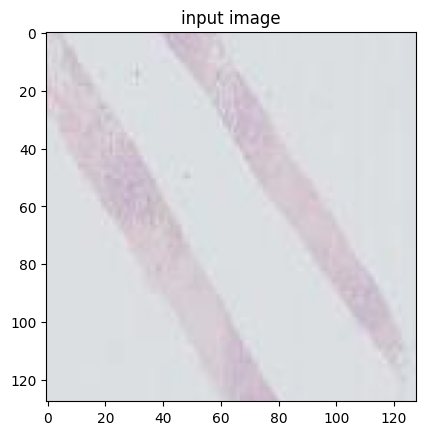

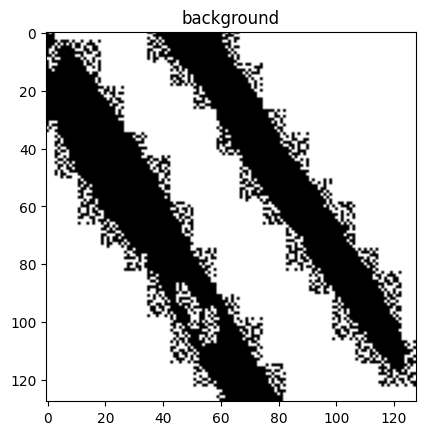

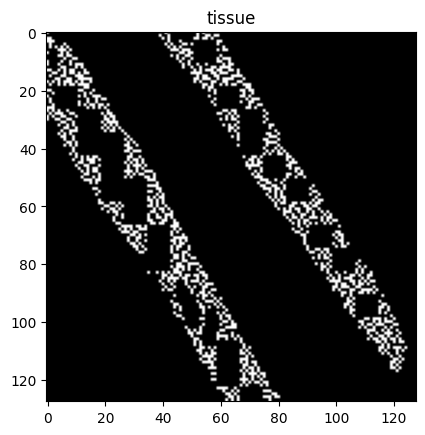

In [4]:
path = "data/tissue"
batch_size=1
patch_size = [128, 128]
nb_channels_out =2
val_datagen = DataGeneratorTissue(path, "val", batch_size,
                                  patch_size, 3, nb_channels_out)

data = val_datagen[0]

plt.title("input image")
plt.imshow(data[0][0,:,:])
plt.show()
plt.title("background")
plt.imshow(data[1][0,:,:,0], cmap="gray")
plt.show()
plt.title("tissue")
plt.imshow(data[1][0,:,:,1], cmap="gray")
plt.show()

# UNet model builder

The deep learning model we will use is a U-Net model, which was initially introduced to perform segmentation on microscopy images (see [paper](https://arxiv.org/abs/1505.04597)).

Implement the encoder and decoder parts of the UNet model with skip connections in the `build_unet_model` function using only `conv_block`, `keras.layers.MaxPooling2D`,`up_sampler` and [`keras.layers.Concatenate`](https://keras.io/api/layers/merging_layers/concatenate/) functions.

There are several ways of implementing this in Keras, here we will use what is called the [Functional API](https://keras.io/api/models/model/). The idea is to start from a *template input*, `keras.Input(shape=(..))`, and to define all the transformations this *input* undergoes. These transformations need to be implemented in the form of `keras` or  `tensorflow` chains of transformations (they are already implemented below).

Once done, the model is build implicitely by wrapping the  `inputs` and `outputs` inside a `keras.Model`

In [5]:
def build_very_simple_model(nb_channels_in,
                            nb_channels_out,
                            unet_filters,
                            image_size=[None, None]):

    inputs = keras.Input([*image_size, nb_channels_in])

    x = keras.layers.Conv2D(filters=256,
                            kernel_size=3,
                            strides=1,
                            padding='same',
                            kernel_initializer='he_normal')(inputs)
    x = keras.layers.ReLU()(x)

    x = keras.layers.Conv2D(filters=1,
                                kernel_size=3,
                                strides=1,
                                padding='same',
                                kernel_initializer='he_normal')(x)
    outputs = tf.math.sigmoid(x)

    model = keras.Model(inputs, outputs)

    return model

In [6]:
def conv_block(filters, strides):
    conv_block = keras.Sequential([keras.layers.Conv2D(filters=filters, kernel_size=3,
                                                        strides=1, padding="same",
                                                        kernel_initializer = "he_normal"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.LeakyReLU(),
                                    keras.layers.Conv2D(filters=filters, kernel_size=3,
                                                        strides=strides, padding="same",
                                                        kernel_initializer = "he_normal"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.LeakyReLU()])
    return conv_block

def final_block(filters, last_activation):
    conv_block = keras.Sequential([keras.layers.Conv2D(filters=filters, kernel_size=3,
                                                        strides=1, padding="same",
                                                        kernel_initializer = "he_normal"),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Activation(last_activation)])
    return conv_block

def up_sampler(filters):
    up_sampler = keras.Sequential([keras.layers.Conv2DTranspose(filters=filters, kernel_size=2,
                                                                strides=2, padding="valid",
                                                                kernel_initializer = "he_normal"),
                                   keras.layers.BatchNormalization(),
                                   keras.layers.LeakyReLU()])
    return up_sampler

def build_unet_model(nb_channels_in, nb_channels_out,
                     unet_filters, last_activation,
                     image_size=[None, None]):
    inputs = keras.Input([*image_size, nb_channels_in])

    skip = []

    ### TO BE IMPLEMENTED ###
    x = inputs

    # Encoder part
    for filters in unet_filters:
        x = conv_block(filters, strides=1)(x)
        skip.append(x)
        x = keras.layers.MaxPooling2D(pool_size=2)(x)

    # Bottleneck
    x = conv_block(unet_filters[-1] * 2, strides=1)(x)

    # Decoder part
    for filters, skip_connection in zip(reversed(unet_filters), reversed(skip)):
        x = up_sampler(filters)(x)
        x = keras.layers.Concatenate()([x, skip_connection])
        x = conv_block(filters, strides=1)(x)

    #########################


    outputs = final_block(nb_channels_out, last_activation)(x)

    unet_model = keras.Model(inputs, outputs)
    return unet_model

# Segmentation loss

The loss used here is the Jaccard loss, also known as Intersection over Union. As we are working with binary images as outputs, we want to maximize the overlap area of ground truth and predicted masks (see [Wikipedia](https://fr.wikipedia.org/wiki/Indice_et_distance_de_Jaccard) for more details).

Implement the computation of the cardinal of the intersection and the union between *y_true* and *y_pred*, stored in the variables *intersection* and *union* for the jaccard index-based loss. The function *K.sum()* should be sufficient to do so.

In [7]:
def jaccard_loss(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    ### TO BE IMPLEMENTED ###
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    #########################

    return 1 - (intersection + smooth) / (union + smooth)

# Data augmentation

Data augmentation enables to generate new elements for our data set by applying some basic transformations to our images. For more examples, see [this tutorial](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/).

In [8]:
def flip_aug(image, label):
    flipped_image = np.flip(image, axis=1)
    flipped_label = np.flip(label, axis=1)
    return flipped_image, flipped_label

def rot_aug(image, label):
    image_rotation = ndimage.rotate(image, angle=random.randint(low=-20, high=20))
    label_rotation = ndimage.rotate(label, angle=random.randint(low=-20, high=20))
    return image_rotation, label_rotation

# Model's training

Launch the training of a UNet with the given hyperparameters on the gpu "gpu:/0" (the first gpu visible by cuda).  
A directory named "models", where are located the models' directories storing the data of the differents models trained, will be created. .  
In a model's directory, named according the model's id and the timestamp of its training (a security to avoid accidental overwriting), are stored the *model_parameters.json*, *best_model_weights.weights.h5* and *log.csv* files.  
Nothing to implement, just run for training.

In [9]:
path = "data/tissue"

models_dir = "models"
if os.path.exists(models_dir) == False:
    os.mkdir(models_dir)

model_id = 1

dt = datetime.now()
timestamp = str(dt.hour) + ':' + str(dt.minute) + ':' + str(dt.second) + '-' + str(dt.day) + ':' + str(dt.month) + ':' + str(dt.year)
model_name = "modelID=" + str(model_id) +  "_timestamp=" + timestamp

model_dir = os.path.join(models_dir, model_name)
if os.path.exists(model_dir) == False:
    os.mkdir(model_dir)

nb_channels_in = 3
nb_channels_out = 2
last_activation = "softmax"
unet_filters = [8, 16, 32, 64]
patch_size = [128, 128]
batch_size = 5
lr = 0.001
nb_epochs = 50

model_parameters = {"nb_channels_in": nb_channels_in,
                    "nb_channels_out": nb_channels_out,
                    "last_activation": last_activation,
                    "unet_filters": unet_filters,
                    "patch_size": patch_size,
                    "batch_size": batch_size,
                    "lr": lr,
                    "nb_epochs": nb_epochs}

json.dump(model_parameters, open(os.path.join(model_dir, "model_parameters.json"), "w"))

model = build_unet_model(nb_channels_in, nb_channels_out, unet_filters, last_activation , image_size = patch_size)
model.summary()

train_datagen = DataGeneratorTissue(path, "train", batch_size,
                                    patch_size, 3, nb_channels_out,
                                    geometric_augmentations=[flip_aug, rot_aug], augmentation_ratio=0.2)

val_datagen = DataGeneratorTissue(path, "val", batch_size,
                                  patch_size, 3, nb_channels_out)

opt = keras.optimizers.Adam(lr)
model.compile(optimizer=opt, loss=jaccard_loss)

model_log_file_path = os.path.join(model_dir, "log.csv")
best_model_weights_file_path = os.path.join(model_dir, "best_model_weights.weights.h5")

callbacks = [
    keras.callbacks.CSVLogger(model_log_file_path),
    keras.callbacks.ModelCheckpoint(best_model_weights_file_path,
                                    save_best_only=True, save_weights_only=True)]


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │        872 │ input_layer[0][0] │
│ (Sequential)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64, 8) │          0 │ sequential[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │      3,616 │ max_pooling2d[0]… │
│ (Sequential)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ sequential_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │     14,144 │ max_pooling2d_1[… │
│ (Sequential)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ sequential_2[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │     55,936 │ max_pooling2d_2[… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 64)  │          0 │ sequential_3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 128) │    222,464 │ max_pooling2d_3[… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 16, 16,    │     33,088 │ sequential_4[0][… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ sequential_5[0][… │
│ (Concatenate)       │ 128)              │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 16, 16,    │    111,232 │ concatenate[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 32, 32,    │      8,352 │ sequential_6[0][… │
│ (Sequential)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ sequential_7[0][… │
│ (Concatenate)       │ 64)               │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 32, 32,    │     27,968 │ concatenate_1[0]… │
│ (Sequential)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 64, 64,    │      2,128 │ sequential_8[0][

 Total params: 489,386 (1.87 MB)

 Trainable params: 487,670 (1.86 MB)

 Non-trainable params: 1,716 (6.70 KB)

In [10]:
model.fit(train_datagen,
          epochs=nb_epochs,
          validation_data=val_datagen,
          verbose=1,
          callbacks=callbacks)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 228ms/step - loss: 0.6288 - val_loss: 0.8334
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.4503 - val_loss: 0.8101
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.4215 - val_loss: 0.5813
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3957 - val_loss: 0.4879
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.3753 - val_loss: 0.4624
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.3747 - val_loss: 0.4799
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3592 - val_loss: 0.4624
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.3564 - val_loss: 0.5113
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.3398 - val_loss: 0.4673
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.3307 - val_loss: 0.4541
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3198 - val_loss: 0.4086
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3220 - val

# Model's training summary

Plot the training and validation loss.  
Nothing to implement.

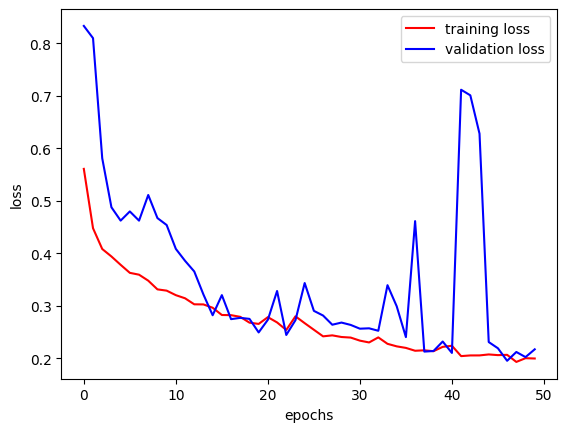

In [11]:
df = pd.read_csv(model_log_file_path, sep=",")
plt.plot(df["epoch"], df["loss"], "r", label="training loss")
plt.plot(df["epoch"], df["val_loss"], "b", label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

# Model's inference function

*make_apply_unet_model* is the function to call to embeds a UNet model into a function in charge of the whole pipeline to get from an 8-bit image an 8-bit binary segmentation mask.  
Implement the *apply_unet_model* function.
Here the pipeline should include:  
* a [0,1]-normalization  
* a padding of the image (so that its dimension are 2^{unet_depth = len(unet_filters)-1} divisible)  
* the application of the UNet model  
* an unpadding of the UNet model's output (to retrieve the initial image dimensions)  
* the conversion of the UNet model's output into a binary segmentation mask by taking the label with the highest probability for each pixel  

The *pad_image* and *unpad_image* are already provided.

In [12]:
def pad_image(image, unet_depth):
    shape = image.shape[:2]
    if shape[0]%2**unet_depth != 0 or shape[1]%2**unet_depth != 0:
        new_shape = [shape[0] + 2**unet_depth - shape[0]%2**unet_depth,
                     shape[1] + 2**unet_depth - shape[1]%2**unet_depth]
        new_image = np.empty([*new_shape, 3])
        new_image[0:shape[0], 0:shape[1], :] = image[...]

        new_image[0:shape[0],shape[1]:new_shape[1],:] = image[:,shape[1]-(new_shape[1]-shape[1]):shape[1],:]
        new_image[shape[0]:new_shape[0],0:shape[1],:] = image[shape[0]-(new_shape[0]-shape[0]):shape[0],:,:]
        new_image[shape[0]:new_shape[0],shape[1]:new_shape[1],:] = image[shape[0]-(new_shape[0]-shape[0]):shape[0],shape[1]-(new_shape[1]-shape[1]):shape[1],:]

        return new_image
    else:
        return image

def unpad_image(image, old_shape):
    im_shape = image.shape[:2]
    if im_shape[0] == old_shape[0] and im_shape[1] == old_shape[1]:
        return image
    else:
        new_image = image[0:old_shape[0], 0:old_shape[1]]
        return new_image

def apply_unet_model(unet_model, unet_depth, image):

    ### TO BE IMPLEMENTED ###
    # Normalize image to [0,1]
    image_norm = image.astype(np.float32) / 255.0

    # Pad image to size divisible by 2**unet_depth
    padded_image = pad_image(image_norm, unet_depth)

    # Add batch and predict
    input_tensor = np.expand_dims(padded_image, axis=0)
    preds = unet_model.predict(input_tensor)

    # Remove batch dimension
    preds = np.squeeze(preds, axis=0)

    # Unpad to original image size
    preds_unpadded = unpad_image(preds, image.shape[:2])

    # Convert to binary mask by taking argmax along channel axis
    segm_binary = np.argmax(preds_unpadded, axis=-1)

    #########################
    return segm_binary

def make_apply_unet_model(unet_model, unet_depth):
    return lambda image: apply_unet_model(unet_model, unet_depth, image)

# Model's application on test dataset

Apply a UNet model on test dataset images.  
The model is chosen with its id.

In [13]:
indexes_to_test = [8, 42, 10, 17, 35]  # indexes in [0, 42]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


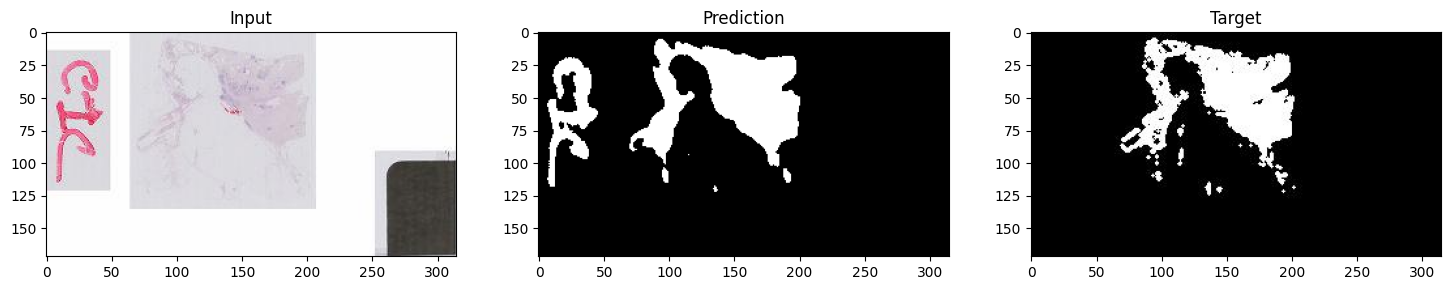

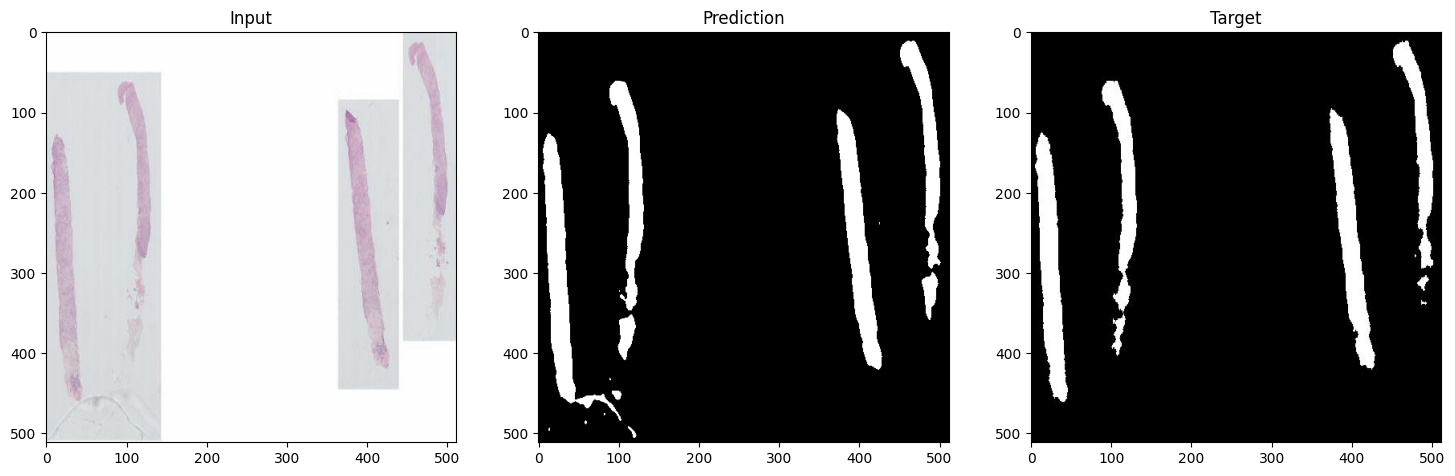

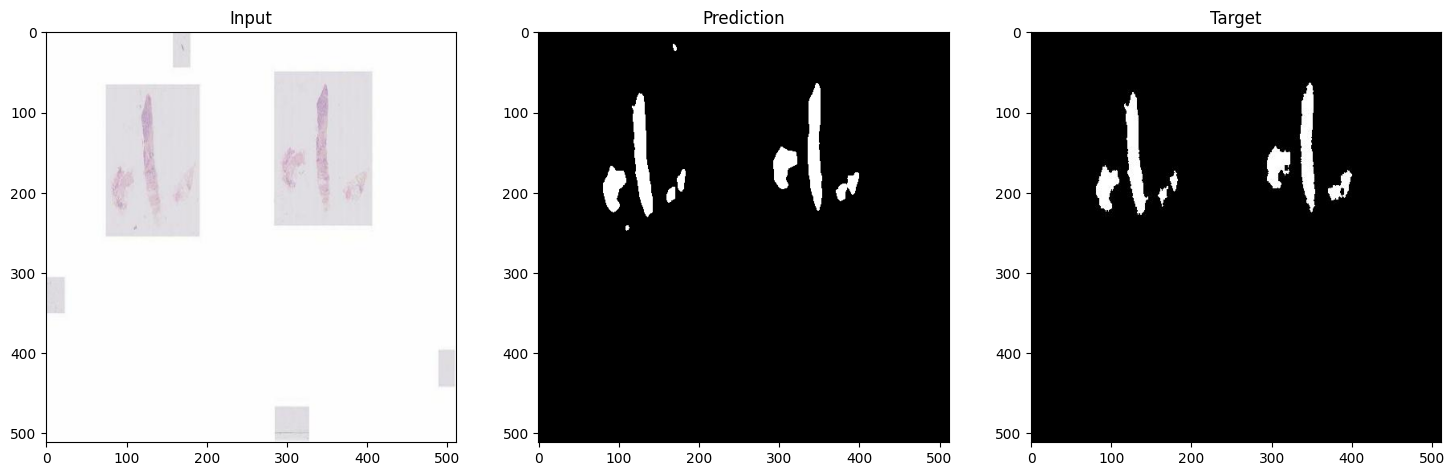

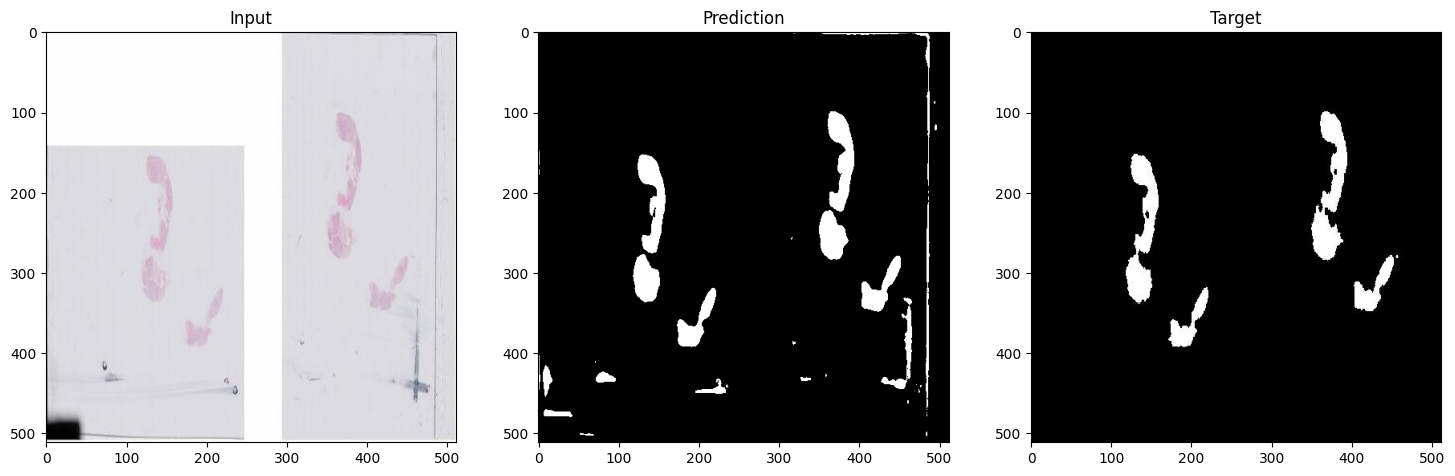

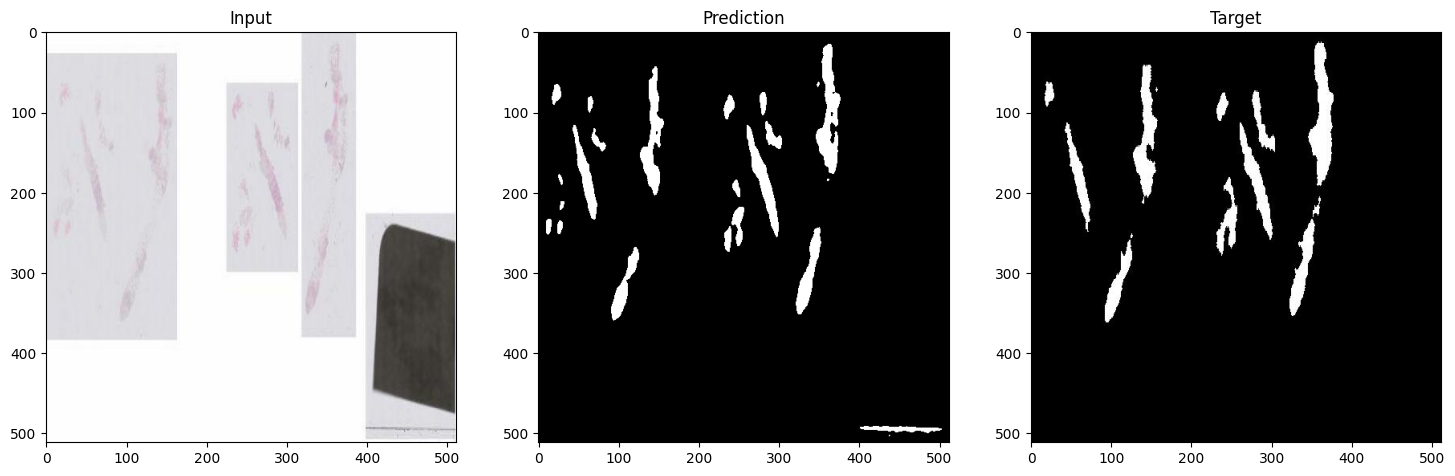

In [14]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

model_idx = -1

models_list = sorted(os.listdir("models"))
model_dir = os.path.join("models", models_list[model_idx])

with open(os.path.join(model_dir, "model_parameters.json"), "r") as model_parameters_file:
    model_parameters = json.load(model_parameters_file)

weights_path = os.path.join(model_dir, "best_model_weights.weights.h5")

model2 = build_unet_model(model_parameters["nb_channels_in"],
                          model_parameters["nb_channels_out"],
                          model_parameters["unet_filters"],
                          model_parameters["last_activation"])

model2.load_weights(weights_path)

apply_model =  make_apply_unet_model(model2, len(model_parameters["unet_filters"])-1)

test_images_dir = os.path.join(path, "test")
test_images_filenames = os.listdir(os.path.join(test_images_dir, "jpg"))

for test_image_idx in indexes_to_test:

  image = imageio.imread(os.path.join(*[test_images_dir, "jpg", test_images_filenames[test_image_idx]]))
  label = imageio.imread(os.path.join(*[test_images_dir, "lbl", test_images_filenames[test_image_idx]]))

  segm = apply_model(image)

  fig, ax = plt.subplots(1, 3, figsize=(18, 18))

  ax[0].imshow(image)
  ax[0].set_title("Input")
  ax[1].imshow(segm, cmap="gray")
  ax[1].set_title("Prediction")
  ax[2].imshow(label, cmap="gray")
  ax[2].set_title("Target")

# Interpretation

Change values of indexes to test with different images.

What do you think about the results? What seems to work? What limitations do you see?

**Answer:** The strong decrease in loss and clear mask outputs shows that this design works well for segmenting biomedical tissues.

While the model usually gives good predictions, it does have some issues. Its performance drops when dealing with images that have unclear or weak boundaries, noisy backgrounds, or uncommon structures. This can lead to some missegmented areas or unclear edges in the prediction masks.

Using geometric data augmentation techniques, like flips and rotations, makes the model more adaptable to changes in orientation and shape. However, it might still struggle with tough cases if the data is very challenging.

Overall, UNet offers high accuracy in segmentation and is a reliable choice for this type of pixelwise annotation. We could improve results further by increasing the diversity of the data, using more advanced augmentation methods, or adding ways to measure uncertainty for difficult examples.